In [1]:
import numpy as np
import pandas_datareader.data as web
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.value_at_risk import CVAROpt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.hierarchical_risk_parity import HRPOpt
from pypfopt.cla import CLA
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [2]:
stocks = ["MSFT","AAPL","AMZN",'NKE','NFLX']
numAssets = len(stocks)
source = 'yahoo'
start = '2017-01-01'
end = '2018-10-31'

data = pd.DataFrame()
#Retrieve stock price data and save just the dividend adjusted closing prices

for symbol in stocks:
        data[symbol] = web.DataReader(symbol, data_source=source, start=start, end=end)['Adj Close']

In [3]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)
num_portfolios = 200
risk_free_rate = 0.0178

In [4]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 103.86
Annualised Volatility: 3.04


            MSFT   AAPL   AMZN   NKE   NFLX
allocation  1.81  41.76  21.76  17.5  17.16
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 87.76
Annualised Volatility: 2.73


             MSFT   AAPL   AMZN    NKE  NFLX
allocation  26.93  25.89  10.39  31.33  5.45


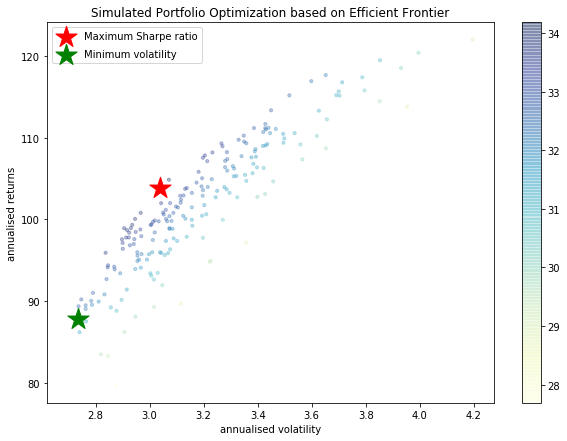

In [5]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

display_simulated_ef_with_random(mu, S, num_portfolios, risk_free_rate)

In [ ]:
import randomport

args = (mu, S, num_portfolios, risk_free_rate)

if __name__ == '__main__':
    p = Pool(multiprocessing.cpu_count())
    results = p.starmap(randomport.display_simulated_ef_with_random, [(data, numAssets, mu, S, num_portfolios, risk_free_rate) for x in range(1000)])
    results = pd.DataFrame(results)
    p.close()
    
rp, sdp, rp_min, sdp_min = results[0].max(), results[1].min(), results[2].max(), results[3].min()
print("-"*80)
print("Maximum Sharpe Ratio Portfolio Allocation\n")
print("Annualised Return:", round(rp,2))
print("Annualised Volatility:", round(sdp,2))
print(results.iloc[results[0].idxmax(), 4])
print("\n")
#print(results[4])
print("-"*80)
print("Minimum Volatility Portfolio Allocation\n")
print("Annualised Return:", round(rp_min,2))
print("Annualised Volatility:", round(sdp_min,2))
print(results.iloc[results[0].idxmin(), 5])
print("\n")
#print(results[5])

In [ ]:
# plt.figure()
# plt.scatter(results[0].values,results[1].values,c=results[2].values,cmap='YlGnBu', marker='o', s=100, alpha=0.3)
# plt.colorbar()
# plt.scatter(sdp,rp,marker='*',color='r',s=100, label='Maximum Sharpe ratio')
# plt.scatter(sdp_min,rp_min,marker='*',color='g',s=100, label='Minimum volatility')
# plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
# plt.xlabel('annualised volatility')
# plt.ylabel('annualised returns')
# plt.legend(labelspacing=0.8)
import plotly.express as px
results.rename(columns={0:"mean", 1:"sd", 2:"mean", 3:"sd_min", 4:"sharpe", 5:"vol", 6:"sharpe_wt", 7:"vol_wt"}, inplace=True)
fig = px.scatter_3d(results, x='sd_min', y='sd', z='mean',
                    color='mean', opacity=0.5)
name = 'Efficient Portfolios'
camera = dict(
    eye=dict(x=1.2, y=1.2, z=1.5)
)
fig.update_layout(scene_camera=camera, title=name, scene = dict(
                    xaxis_title='Min. Risk per iteration',
                    yaxis_title='Optimal return per iteration',
                    zaxis_title='Optimal risk per iteration'))
fig.show()

In [8]:
def measureTimeNew(n):
    import time
    import randomport
    from multiprocessing import Pool
    '''Function to calculate the time taken for any function to execute'''
    
    num_portfolios = n
    startTime = time.time()  # setting start time when function starts
    if __name__ == '__main__':
        p = Pool(8)
        p.starmap(randomport.display_simulated_ef_with_random, [(data,numAssets, mu, S, num_portfolios, risk_free_rate) for x in range(100)])
    endTime = time.time()   #setting end time when function ends
    return endTime-startTime  #time take which is equal difference of end time and side time

# grid=np.arange(1000)
# t1s = np.zeros_like(grid) 
# t2s = np.zeros_like(grid)
n = 50
t1s = np.zeros(n)
for i in range(n):
    t1s[i] = measureTimeNew(i+1)
print(t1s)

[1.70493555 2.34246516 3.03200126 2.37931108 2.2359643  4.61362672
 4.50367594 4.84367323 1.88033319 2.93482876 5.25012374 1.87686229
 4.49264765 4.08477211 2.83612585 5.67617822 5.88332534 4.15697145
 7.31442738 4.47199297 4.28853464 4.68558025 4.57744694 2.95615602
 3.43678212 5.76217413 3.55631948 2.96905017 4.6465292  3.07767797
 5.05963874 3.27468753 5.76401973 3.62426662 4.7074697  3.4163475
 4.58014441 5.66244841 3.53605747 5.07332993 4.9699955  4.7605741
 5.20203996 5.28014207 5.25275874 5.3137238  5.10334158 5.39983916
 5.35658336 5.41274738]


In [9]:
def measureTime(n):
    import time
    '''Function to calculate the time taken for any function to execute'''
    
    num_portfolios = n
    startTime = time.time()  # setting start time when function starts
    display_simulated_ef_with_random(data,numAssets, mu, S, num_portfolios, risk_free_rate)
    endTime = time.time()   #setting end time when function ends
    return endTime-startTime  #time take which is equal difference of end time and side time

n = 30
t2s = np.zeros(n)
for i in range(n):
    t2s[i] = measureTimeNew(i+1)
print(t2s)

[ 4.88358593  4.74245834  4.68040562  4.78800559  4.83527279  4.65465331
  4.38792276  4.79209375  4.88269448  4.70363212  4.72735834  4.90611935
  4.97838664  5.37625933  5.03704476  5.09075999  5.00732136  2.48293447
  4.68558598  4.81522441  8.0301609   7.66179895  6.0917511   3.69950128
  3.31247687  3.60846853  6.85450602 10.37932515  7.88384652  6.18560958]


In [19]:
ptime = pd.DataFrame({'time':t1s, 'datasize':list(range(1,51)), 'type':['Parallel']*50})
ntime = pd.DataFrame({'time':t2s, 'datasize':list(range(1,31)), 'type':['Normal']*30})
final = pd.concat([ptime,ntime])
import plotly.express as px
fig = px.line(final, x="datasize", y="time", color='type')
fig.show()

In [ ]:
# # Long-only Maximum Sharpe portfolio, with discretised weights
# ef = EfficientFrontier(mu, S)
# weights = ef.max_sharpe()
# ef.portfolio_performance(verbose=True)
# latest_prices = get_latest_prices(data)
# if __name__ == '__main_':
#     p = Pool(4)
#     da = p.map(DiscreteAllocation(weights,latest_prices), weights)
#     ef = p.map(EfficientFrontier(mu, S, weight_bounds=(0, 0.10), gamma=1), s)

# allocation, leftover = da.lp_portfolio()
# print('------------------------------- DA ------------------------------------')
# print("Discrete allocation:", allocation)
# print("Funds remaining: ${:.2f}".format(leftover))
# print('------------------------------- EF Min Vol ------------------------------------')
# weights = ef.min_volatility()
# print(weights)
# ef.portfolio_performance(verbose=True)

In [ ]:
# # Long-only Maximum Sharpe portfolio, with discretised weights
# ef = EfficientFrontier(mu, S)
# weights = ef.max_sharpe()
# ef.portfolio_performance(verbose=True)
# latest_prices = get_latest_prices(data)

# da = DiscreteAllocation(weights, latest_prices)
# allocation, leftover = da.lp_portfolio()
# print("Discrete allocation:", allocation)
# print("Funds remaining: ${:.2f}".format(leftover))

In [ ]:
# # Long-only minimum volatility portfolio, with a weight cap and regularisation
# # e.g if we want at least 15/20 tickers to have non-neglible weights, and no
# # asset should have a weight greater than 10%
# ef = EfficientFrontier(mu, S, weight_bounds=(0, 0.10), gamma=1)
# weights = ef.min_volatility()
# print(weights)
# ef.portfolio_performance(verbose=True)

In [ ]:
# # A long/short portfolio maximising return for a target volatility of 10%,
# # with a shrunk covariance matrix risk model
# shrink = risk_models.CovarianceShrinkage(data)
# S = shrink.ledoit_wolf()
# ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
# weights = ef.efficient_risk(target_risk=0.10)
# ef.portfolio_performance(verbose=True)

In [ ]:
# # A market-neutral Markowitz portfolio finding the minimum volatility
# # for a target return of 20%
# ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
# weights = ef.efficient_return(target_return=0.20, market_neutral=True)
# ef.portfolio_performance(verbose=True)

In [ ]:
# # Custom objective
# def utility_obj(weights, mu, cov_matrix, k=1):
#     return -weights.dot(mu) + k * np.dot(weights.T, np.dot(cov_matrix, weights))


# ef = EfficientFrontier(mu, S)
# ef.custom_objective(utility_obj, ef.expected_returns, ef.cov_matrix, 1)
# ef.portfolio_performance(verbose=True)

In [ ]:
# # Crticial Line Algorithm
# cla = CLA(mu, S)
# print(cla.max_sharpe())
# cla.portfolio_performance(verbose=True)

In [ ]:
# def sumFunction(n):
#     mySum=0
#     for i in range(n):
#         mySum+=i
#     return mySum

# if __name__ == '__main__':
#     for i in range(1,10):
#         p = Pool(processes=i)
#         #startTime=time.time()
#         p.map(sumFunction, [20000000 for x in range(12)])
#         #endTime=time.time()
#         p.close()
#         #print("Using ",i," processors it took", endTime-startTime, " seconds")